In [113]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv

from seaborn_analyzer import CustomPairPlot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import VarianceThreshold

from tqdm import tqdm
from IPython.display import HTML


import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 2000)

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# 各遺伝子データの読み込み

In [77]:
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T

df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
)

df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
)

df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop("Entrez_Gene_Id")

# 　ファイルの中身が壊れているため、使用するなら要修正
# df_mutations = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_mutations.txt").T


# 各dfの中身変更防止の為setを仕様
df_set = (
    df_cna,
    df_methylation_promoters_rrbs,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    df_mrna_agilent_microarray,
    # df_mutations
)
df_name_set = (
    "df_cna",
    "df_methylation_promoters_rrbs",
    "df_mrna_agilent_microarray_zscores_ref_all_samples",
    "df_mrna_agilent_microarray_zscores_ref_diploid_samples",
    "df_mrna_agilent_microarray",
    # "df_mutations"
)

## 特徴量が重複していないか確認
遺伝子名が数多く存在するので、特徴量の名前に重複がないか確認する。

In [78]:
# df内で重複しているcolumnsを表示するだけの関数
# 入力：サンプルx特徴量形式のpd.DataFrame()
def show_duplicate_columns(df: pd.DataFrame(), show_detail: bool = False):
    list_dup = []
    for k, v in collections.Counter(df.columns.tolist()).items():
        if v > 1:
            list_dup.append(k)
            if show_detail:
                print(k)
    print(len(list_dup))


for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "の重複columns数", "*****" * 5)
    show_duplicate_columns(df)

************************* df_cna の重複columns数 *************************
1
************************* df_methylation_promoters_rrbs の重複columns数 *************************
0
************************* df_mrna_agilent_microarray_zscores_ref_all_samples の重複columns数 *************************
168
************************* df_mrna_agilent_microarray_zscores_ref_diploid_samples の重複columns数 *************************
261
************************* df_mrna_agilent_microarray の重複columns数 *************************
168


In [79]:
# shapeの確認
print(df_name_set)
print([df.shape for df in df_set])

('df_cna', 'df_methylation_promoters_rrbs', 'df_mrna_agilent_microarray_zscores_ref_all_samples', 'df_mrna_agilent_microarray_zscores_ref_diploid_samples', 'df_mrna_agilent_microarray')
[(2173, 22544), (1418, 13188), (1904, 24368), (1904, 18543), (1904, 24368)]


In [83]:
# total null num

for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "の合計null数", "*****" * 5)
    print(df.isnull().sum().sum())
    print("*****" * 5, df_name, "で全てnullの特徴量の数", "*****" * 5)
    print(df.isnull().all().sum())
    print("*****" * 5, df_name, "で少なくとも1つnullの持つ特徴量の数", "*****" * 5)
    print(df.isnull().any().sum())
    print("*****" * 5, df_name, "の各columnsのnullの数（多い順）", "*****" * 5)
    print(df.isnull().sum().sort_values(ascending=False).head())

************************* df_cna の合計null数 *************************
2356
************************* df_cna で全てnullの特徴量の数 *************************
0
************************* df_cna で少なくとも1つnullの持つ特徴量の数 *************************
465
************************* df_cna の各columnsのnullの数（多い順） *************************
Hugo_Symbol
LCE3C       41
GSTT1       35
GSTM1       31
HLA-DRB5    29
TAS2R43     29
dtype: int64
************************* df_methylation_promoters_rrbs の合計null数 *************************
555316
************************* df_methylation_promoters_rrbs で全てnullの特徴量の数 *************************
0
************************* df_methylation_promoters_rrbs で少なくとも1つnullの持つ特徴量の数 *************************
10149
************************* df_methylation_promoters_rrbs の各columnsのnullの数（多い順） *************************
Hugo_Symbol
CUL5       432
PHYHD1     427
ANKRD6     427
MIR1193    426
TTC39A     426
dtype: int64
************************* df_mrna_agilent_microarray_zscores_ref_all_samples の

In [81]:
# Finding missing data and the percentage of it in each column

for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "の各columnsのnullの全体データ数に対する割合", "*****" * 5)
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent], axis=1, keys=["Total_NaN", "Percent_Nan"]
    )
    display(missing_data.head())

************************* df_cna の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
LCE3C               41     0.018868
GSTT1               35     0.016107
GSTM1               31     0.014266
HLA-DRB5            29     0.013346
TAS2R43             29     0.013346

************************* df_methylation_promoters_rrbs の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
CUL5               432     0.304654
PHYHD1             427     0.301128
ANKRD6             427     0.301128
MIR1193            426     0.300423
TTC39A             426     0.300423

************************* df_mrna_agilent_microarray_zscores_ref_all_samples の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
SLC25A19             2     0.001050
CSNK2A1              2     0.001050
FAM71A               1     0.000525
TMPRSS7              1     0.000525
MRPL24               1     0.000525

************************* df_mrna_agilent_microarray_zscores_ref_diploid_samples の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                         
LOC100127910       1904          1.0
LOC286083          1904          1.0
SAGE2P             1904          1.0
PRO0611            1904          1.0
LOC401312          1904          1.0

************************* df_mrna_agilent_microarray の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
SLC25A19             2     0.001050
CSNK2A1              2     0.001050
FAM71A               1     0.000525
TMPRSS7              1     0.000525
MRPL24               1     0.000525

************************* df_cna のnull数の可視化 *************************


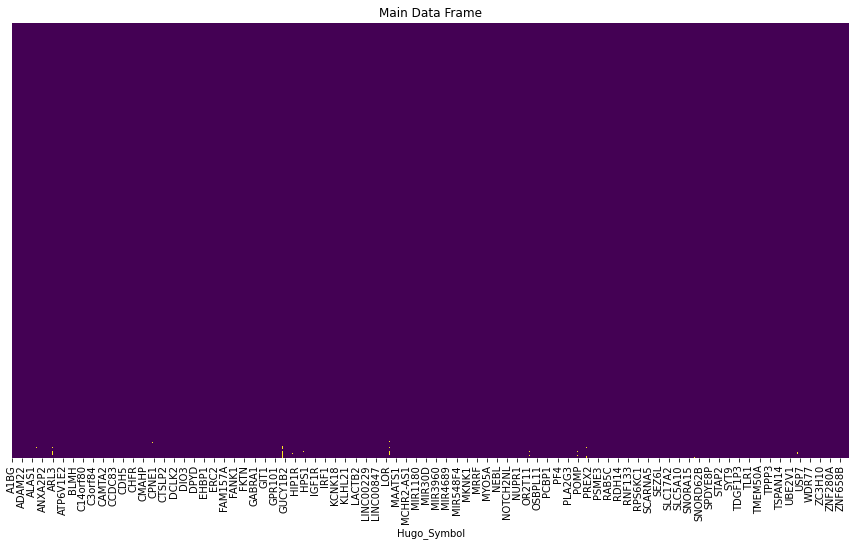

************************* df_methylation_promoters_rrbs のnull数の可視化 *************************


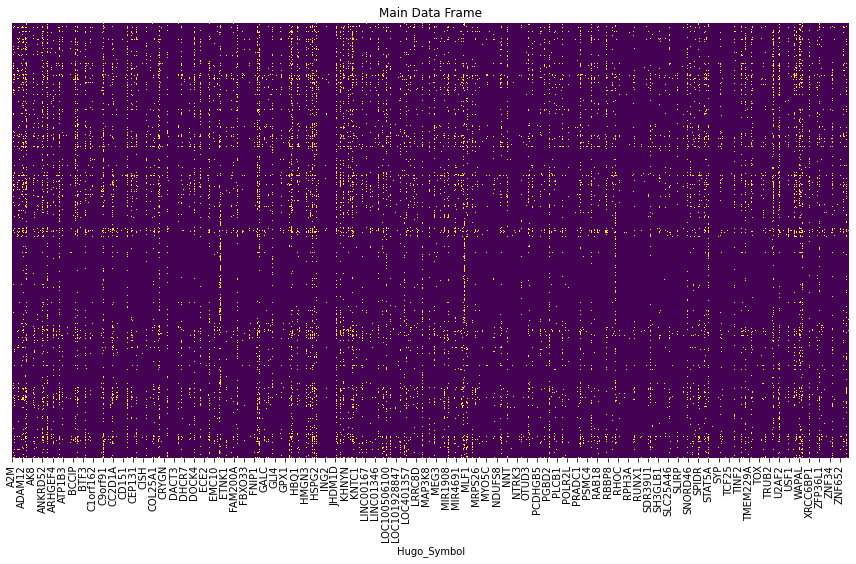

************************* df_mrna_agilent_microarray_zscores_ref_all_samples のnull数の可視化 *************************


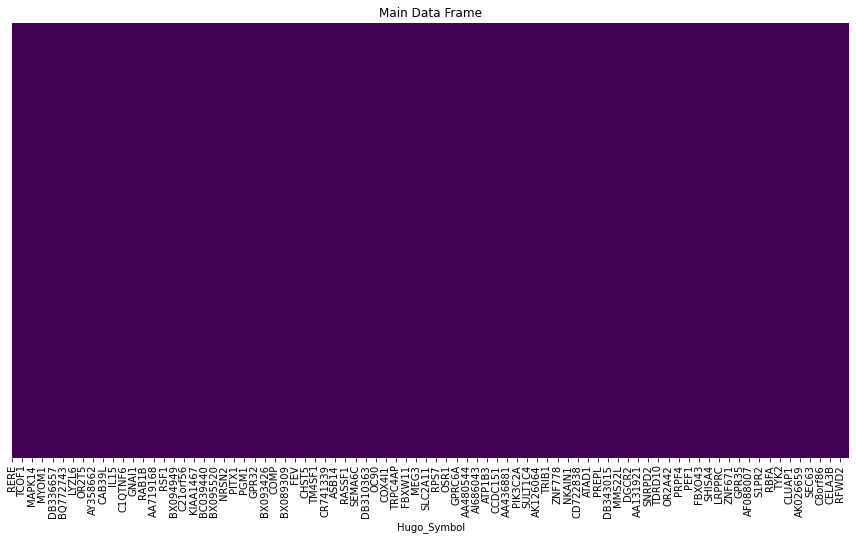

************************* df_mrna_agilent_microarray_zscores_ref_diploid_samples のnull数の可視化 *************************


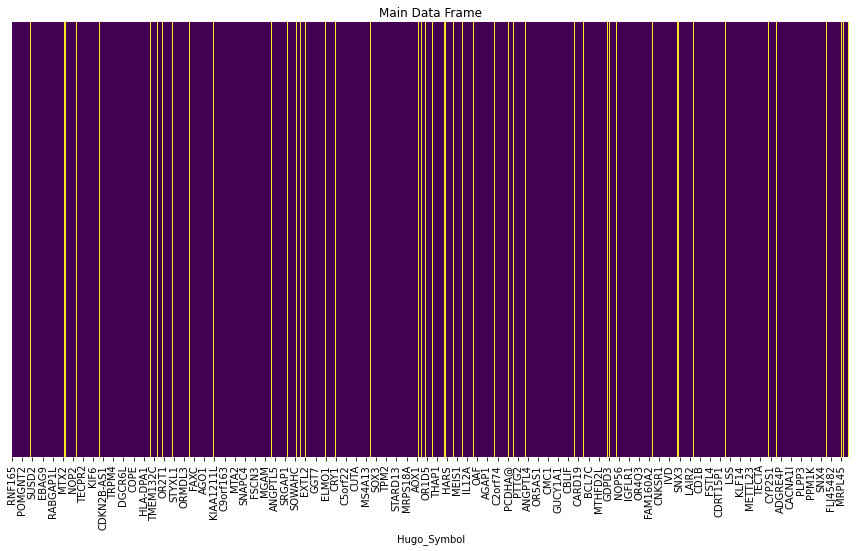

************************* df_mrna_agilent_microarray のnull数の可視化 *************************


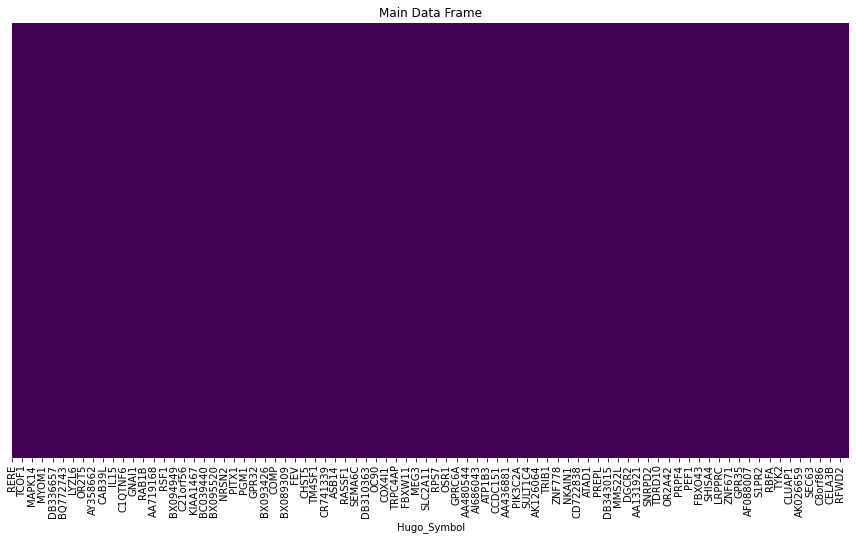

In [82]:
# Visualization of missing data
%matplotlib inline


for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "のnull数の可視化", "*****" * 5)
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")
    ax.set_title("Main Data Frame")
    plt.show();

## indexと対応させるために読み込み

### 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

#### 目的変数｜5年後の予後の2値分類
5年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [9]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [10]:
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")

df_MB["target_OS_5years"] = np.nan
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].mask(
    df_MB["OS_MONTHS"] > 60, False
)
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].mask(
    (df_MB["OS_MONTHS"] <= 60) & (df_MB["VITAL_STATUS"] == "Died of Disease"),
    True,
)
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].astype(bool)
# targetを定義できなかったデータは除く
# df_MB = df_MB[df_MB["target_OS_5years"].notnull()]

# 治療クラスの値変更
df_MB["HORMONE_THERAPY"].replace({"YES": 1, "NO": 0}, inplace=True)
df_MB["RADIO_THERAPY"].replace({"YES": 1, "NO": 0}, inplace=True)
df_MB["BREAST_SURGERY"].replace({"BREAST CONSERVING": 1, "MASTECTOMY": 0}, inplace=True)

# 目的変数生成で使用した特徴量を削除
df_MB.drop(["OS_MONTHS", "OS_STATUS", "VITAL_STATUS"], axis=1, inplace=True)

# df_mrna_agilent_microarrayについてEDA

## 基本事項の確認

In [162]:
# headの確認
df_mrna_agilent_microarray.head()

Hugo_Symbol      RERE    RNF165  CD049690  BC033982      PHF7      CIDEA     PAPD4  AI082173   SLC17A3       SDS  ATP6V1C2        F3    FAM71C  AK055082  BU687559     LIN52     PCOTH      GRM1       FXN     SLC9A1       PML  CR749394     CD164  DB337918   MOBKL2A  ...   TMEM146  SLIT3-AS1   PSMC3IP     TEAD1  LOC253724  BM725158     GRHPR      EGLN2    TBC1D4   ANGPTL2  AF086457  AK124197     ENOX1  SBF2-AS1     VN1R4  BX115874  BX107598    UGCGL1     VPS72     CSMD3    CC2D1A  CB986545     IGSF9  DA110839    FAM71A
MB-0362      8.676978  6.075331  5.453928  4.994525  5.838270   6.397503  7.906217  5.259461  5.702379  6.930741  5.332863  5.275676  5.443896  5.391825  5.332039  6.654909  6.116269  5.502459  6.170848  10.014262  6.223714  5.282517  5.453830  5.393823  6.781114  ...  5.345515   5.289049  6.642358  5.384824   5.624982  5.244877  8.245886  11.179554  6.108972  9.144958  5.172836  5.623032  5.548618  5.335488  5.309543  5.271343  5.680321  7.688492  8.084979  5.161796  6.353215  4.836483  7.304643  5.251843  5.049591
MB-0346      9.653589  6.687887  5.454185  5.346010  5.600876   5.246319  8.267256  5.380069  5.521794  6.141689  7.563477  5.376381  5.319857  5.493960  4.974668  6.546139  5.496121  5.396100  6.462099   9.348527  5.771658  5.312611  5.856599  5.038963  6.932299  ...  5.469792   5.614731  6.305837  5.835178   5.372428  5.174309  7.636559   9.593976  6.708027  7.387434  5.468569  5.482444  5.451468  5.471839  5.579198  5.942887  5.461069  7.804165  8.349115  5.197392  6.132355  5.316819  7.933324  5.450611  5.316790
MB-0386      9.033589  5.910885  5.501577  5.247467  6.030718  10.111816  7.959291  5.262024  5.689533  6.529312  5.482155  5.463788  5.254294  5.405767  5.306545  6.290807  6.202997  5.166248  5.881027   8.811785  6.532682  5.436369  5.381199  5.451264  6.671176  ...  5.314732   5.173775  5.937808  5.676467   5.541437  5.261631  8.105658  11.108679  6.977441  9.030003  5.235995  5.641355  5.762705  5.322604  5.484665  5.174498  5.304030  7.934309  8.406332  8.087722  6.366335  5.466419  7.580336  5.235394  5.461617
MB-0574      8.814855  5.628740  5.471941  5.316523  5.849428   6.116868  9.206376  5.396576  5.439130  6.430102  5.398675  5.409761  5.512298  5.452995  5.409993  6.270448  5.882995  5.314793  6.059837   8.952057  6.113587  5.539569  5.897422  5.602036  6.708135  ...  5.294164   5.420128  6.413538  5.457784   5.438267  5.126400  7.992744  10.642113  6.999086  7.219965  5.655266  5.966010  5.792747  5.520733  5.419803  5.116749  5.632249  7.744562  8.310019  5.780062  6.424048  5.193150  6.903654  5.091927  5.227130
MB-0503      9.274265  5.908698  5.531743  5.244094  5.964661   7.828171  8.706646  5.167213  5.417484  6.684893  5.266674  5.490693  5.363378  5.635478  5.376543  6.575093  5.766303  5.303814  6.427345   9.294008  6.218404  5.121197  5.424916  5.536605  6.972232  ...  5.129111   5.388149  6.773850  6.146829   5.334199  5.400822  8.053461  10.114433  6.283907  8.751008  5.425088  5.838210  5.396735  5.492591  5.324644  5.402314  5.472185  7.701394  8.137014  5.498185  6.214301  5.274600  6.839417  5.315224  5.027476

[5 rows x 24368 columns]

### nullについて調査

全null数
0
全てnullの特徴量数
0
少なくとも1つはnullを持つ特徴量数
0
少なくとも1つはnullを持つサンプル数
0


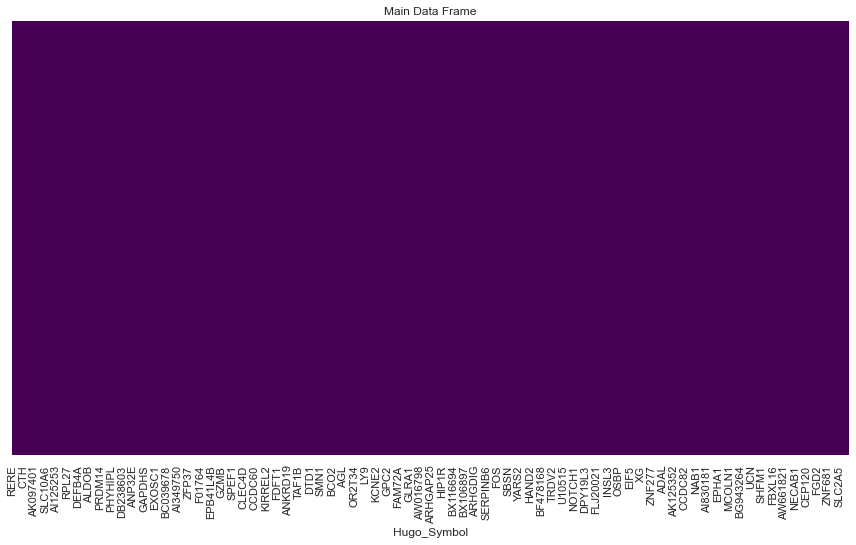

In [163]:
# nullで構成されている特徴量数

print("全null数")
print(df_mrna_agilent_microarray.isnull().sum().sum())
print("全てnullの特徴量数")
print(df_mrna_agilent_microarray.isnull().all().sum())
print("少なくとも1つはnullを持つ特徴量数")
print(df_mrna_agilent_microarray.isnull().any().sum())
print("少なくとも1つはnullを持つサンプル数")
print(df_mrna_agilent_microarray.isnull().any(axis=1).sum())

# plot（再掲）
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    df_mrna_agilent_microarray.isnull(), yticklabels=False, cbar=False, cmap="viridis"
)
ax.set_title("Main Data Frame")
plt.show();

null数自体10個と少なく、10サンプルに散らばってしまっていはいるが、全体の1%に満たない量なので、サンプル（データ）数を削除する方向で前処理したほうが良さそう

In [167]:
df_mrna_agilent_microarray.dropna(inplace=True)
df_mrna_agilent_microarray.astype(float)

Hugo_Symbol      RERE    RNF165  CD049690  BC033982      PHF7      CIDEA     PAPD4  AI082173   SLC17A3       SDS  ATP6V1C2        F3    FAM71C  AK055082  BU687559     LIN52     PCOTH      GRM1       FXN     SLC9A1       PML  CR749394     CD164  DB337918   MOBKL2A  ...   TMEM146  SLIT3-AS1   PSMC3IP     TEAD1  LOC253724  BM725158     GRHPR      EGLN2    TBC1D4    ANGPTL2  AF086457  AK124197     ENOX1  SBF2-AS1     VN1R4  BX115874  BX107598    UGCGL1     VPS72     CSMD3    CC2D1A  CB986545     IGSF9  DA110839    FAM71A
MB-0362      8.676978  6.075331  5.453928  4.994525  5.838270   6.397503  7.906217  5.259461  5.702379  6.930741  5.332863  5.275676  5.443896  5.391825  5.332039  6.654909  6.116269  5.502459  6.170848  10.014262  6.223714  5.282517  5.453830  5.393823  6.781114  ...  5.345515   5.289049  6.642358  5.384824   5.624982  5.244877  8.245886  11.179554  6.108972   9.144958  5.172836  5.623032  5.548618  5.335488  5.309543  5.271343  5.680321  7.688492  8.084979  5.161796  6.353215  4.836483  7.304643  5.251843  5.049591
MB-0346      9.653589  6.687887  5.454185  5.346010  5.600876   5.246319  8.267256  5.380069  5.521794  6.141689  7.563477  5.376381  5.319857  5.493960  4.974668  6.546139  5.496121  5.396100  6.462099   9.348527  5.771658  5.312611  5.856599  5.038963  6.932299  ...  5.469792   5.614731  6.305837  5.835178   5.372428  5.174309  7.636559   9.593976  6.708027   7.387434  5.468569  5.482444  5.451468  5.471839  5.579198  5.942887  5.461069  7.804165  8.349115  5.197392  6.132355  5.316819  7.933324  5.450611  5.316790
MB-0386      9.033589  5.910885  5.501577  5.247467  6.030718  10.111816  7.959291  5.262024  5.689533  6.529312  5.482155  5.463788  5.254294  5.405767  5.306545  6.290807  6.202997  5.166248  5.881027   8.811785  6.532682  5.436369  5.381199  5.451264  6.671176  ...  5.314732   5.173775  5.937808  5.676467   5.541437  5.261631  8.105658  11.108679  6.977441   9.030003  5.235995  5.641355  5.762705  5.322604  5.484665  5.174498  5.304030  7.934309  8.406332  8.087722  6.366335  5.466419  7.580336  5.235394  5.461617
MB-0574      8.814855  5.628740  5.471941  5.316523  5.849428   6.116868  9.206376  5.396576  5.439130  6.430102  5.398675  5.409761  5.512298  5.452995  5.409993  6.270448  5.882995  5.314793  6.059837   8.952057  6.113587  5.539569  5.897422  5.602036  6.708135  ...  5.294164   5.420128  6.413538  5.457784   5.438267  5.126400  7.992744  10.642113  6.999086   7.219965  5.655266  5.966010  5.792747  5.520733  5.419803  5.116749  5.632249  7.744562  8.310019  5.780062  6.424048  5.193150  6.903654  5.091927  5.227130
MB-0503      9.274265  5.908698  5.531743  5.244094  5.964661   7.828171  8.706646  5.167213  5.417484  6.684893  5.266674  5.490693  5.363378  5.635478  5.376543  6.575093  5.766303  5.303814  6.427345   9.294008  6.218404  5.121197  5.424916  5.536605  6.972232  ...  5.129111   5.388149  6.773850  6.146829   5.334199  5.400822  8.053461  10.114433  6.283907   8.751008  5.425088  5.838210  5.396735  5.492591  5.324644  5.402314  5.472185  7.701394  8.137014  5.498185  6.214301  5.274600  6.839417  5.315224  5.027476
...               ...       ...       ...       ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...        ...       ...       ...       ...       ...       ...  ...       ...        ...       ...       ...        ...       ...       ...        ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...
MB-5465      8.131637  9.101942  5.423027  4.939292  5.644587   5.611189  7.798269  5.219962  5.597732  6.583524  5.514106  6.573131  5.367170  5.333079  5.067339  5.979393  5.631939  5.381806  6.164739   8.722484  6.661253  5.577581  6.489781  5.149507  6.508675  ...  5.504469   5.172399  5.915299  5.507574   5.440004  5.423530  8.34753

### df_MBの読み込み

df_MB（patient_idと目的変数のみ）とdf_cnaをpatient_id（Hugo_Symbol：reset_indexによってindexがHugo_Symbolとなっている）をキーとして結合

In [265]:
df_MB_genes = pd.merge(
    df_MB[
        [
            "PATIENT_ID",
            "target_OS_5years",
            # "HORMONE_THERAPY",
            # "RADIO_THERAPY",
            # "BREAST_SURGERY",
        ]
    ],
    df_mrna_agilent_microarray.reset_index(),
    right_on="index",
    left_on="PATIENT_ID",
).drop("index", axis=1)

df_MB_genes = df_MB_genes.set_index("PATIENT_ID")

# データ形状の確認
print(
    df_mrna_agilent_microarray.shape,
    df_MB.shape,
    df_MB_genes.shape,
    # targetがnullのデータが紛れていないか
    df_MB_genes[df_MB_genes.target_OS_5years != np.nan].shape,
)

df_MB_genes.head()

(1894, 24368) (1985, 34) (1894, 24369) (1894, 24369)


target_OS_5years      RERE    RNF165  CD049690  BC033982      PHF7      CIDEA     PAPD4  AI082173   SLC17A3       SDS  ATP6V1C2        F3    FAM71C  AK055082  BU687559     LIN52     PCOTH      GRM1       FXN    SLC9A1       PML  CR749394     CD164  DB337918  ...   TMEM146  SLIT3-AS1   PSMC3IP     TEAD1  LOC253724  BM725158     GRHPR      EGLN2    TBC1D4   ANGPTL2  AF086457  AK124197     ENOX1  SBF2-AS1     VN1R4  BX115874  BX107598    UGCGL1     VPS72     CSMD3    CC2D1A  CB986545     IGSF9  DA110839    FAM71A
PATIENT_ID                                                                                                                                                                                                                                                                     ...                                                                                                                                                                                                                                                             
MB-0000                False  9.738092  6.469688  5.457135  5.106495  5.652674  11.558869  8.340484  5.384699  5.648494  5.336235  5.468668  7.070649  5.477154  5.489805  5.318898  6.811309  5.440853  5.361170  5.823306  8.809831  6.790593  5.595347  6.141047  5.481023  ...  5.353135   5.198876  5.901473  5.610397   5.515762  5.213511  8.139151  10.232505  7.311327  9.677952  5.318426  5.635153  5.918239  5.295203  5.474224  5.329883  5.745324  7.021679  8.010657  5.299815  6.235804  5.349555  5.947404  5.615147  5.133576
MB-0002                False  9.013876  5.748717  5.699735  5.419119  5.611212   6.199492  8.341091  5.490558  5.789506  5.700974  5.495295  6.098949  5.589824  5.055598  5.489397  6.952007  5.545206  5.579463  6.341935  9.307305  6.132436  5.328097  6.400910  5.531249  ...  4.888335   5.615278  6.447777  5.950548   5.502117  5.124030  8.261487  10.186566  6.324112  8.895600  5.345262  6.281727  5.515844  5.442257  5.303871  5.384794  5.285060  7.612797  7.988643  5.194247  6.328059  5.469445  6.938685  5.231857  5.604560
MB-0005                False  7.963493  5.553056  5.472386  5.265556  5.793398   6.489781  8.862815  5.538854  5.566713  7.233671  5.537530  6.964546  5.255454  5.374815  5.668776  6.480061  5.790445  5.462634  5.807004  8.477327  5.572601  5.539776  8.575001  5.562090  ...  5.313808   5.508167  6.076896  5.747801   5.368297  5.371385  7.731911   9.954702  7.222594  8.972083  5.420388  5.404494  5.350242  5.368716  5.370394  5.336455  5.452393  6.619220  8.044471  5.306294  6.306927  5.362207  7.397672  5.372138  5.645597
MB-0006                False  8.177157  5.391160  5.529795  5.011812  5.807604   5.319779  8.693784  5.430685  5.539252  6.124384  6.657355  6.409554  5.289307  5.299305  5.112324  5.987913  5.393475  5.282728  5.985588  8.101386  5.808433  5.345124  9.164529  5.336013  ...  5.228991   5.324400  5.650472  5.579526   5.303998  5.351482  8.301195  10.088769  7.053031  8.664307  5.370416  5.480761  5.650978  5.295628  5.694697  5.663304  5.529928  6.966482  7.527300  5.197607  6.515638  5.309927  6.175716  5.586521  5.354582
MB-0008                 True  8.050127  5.530582  5.303667  5.149618  5.934570   8.787583  8.055626  5.239388  5.646685  7.155642  5.878104  5.798117  5.297733  5.610297  5.141883  6.675580  6.598310  5.328773  6.200995  9.301414  6.182025  5.384272  5.904271  5.457066  ...  5.322069   5.136661  6.403137  5.904885   5.473140  5.460753  8.007261  11.244345  5.926732  8.141539  5.217030  5.442109  5.527755  5.192858  5.474929  5.799346  5.597297  6.942461  8.115359  5.254136  6.323751  5.518767  6.272568  5.204630  5.030636

[5 rows x 24369 columns]

### 特徴量の値の分布について調査

In [266]:
df_MB_genes

target_OS_5years      RERE    RNF165  CD049690  BC033982      PHF7      CIDEA     PAPD4  AI082173   SLC17A3       SDS  ATP6V1C2        F3    FAM71C  AK055082  BU687559     LIN52     PCOTH      GRM1       FXN    SLC9A1       PML  CR749394     CD164  DB337918  ...   TMEM146  SLIT3-AS1   PSMC3IP     TEAD1  LOC253724  BM725158     GRHPR      EGLN2    TBC1D4   ANGPTL2  AF086457  AK124197     ENOX1  SBF2-AS1     VN1R4  BX115874  BX107598    UGCGL1     VPS72     CSMD3    CC2D1A  CB986545     IGSF9  DA110839    FAM71A
PATIENT_ID                                                                                                                                                                                                                                                                     ...                                                                                                                                                                                                                                                             
MB-0000                False  9.738092  6.469688  5.457135  5.106495  5.652674  11.558869  8.340484  5.384699  5.648494  5.336235  5.468668  7.070649  5.477154  5.489805  5.318898  6.811309  5.440853  5.361170  5.823306  8.809831  6.790593  5.595347  6.141047  5.481023  ...  5.353135   5.198876  5.901473  5.610397   5.515762  5.213511  8.139151  10.232505  7.311327  9.677952  5.318426  5.635153  5.918239  5.295203  5.474224  5.329883  5.745324  7.021679  8.010657  5.299815  6.235804  5.349555  5.947404  5.615147  5.133576
MB-0002                False  9.013876  5.748717  5.699735  5.419119  5.611212   6.199492  8.341091  5.490558  5.789506  5.700974  5.495295  6.098949  5.589824  5.055598  5.489397  6.952007  5.545206  5.579463  6.341935  9.307305  6.132436  5.328097  6.400910  5.531249  ...  4.888335   5.615278  6.447777  5.950548   5.502117  5.124030  8.261487  10.186566  6.324112  8.895600  5.345262  6.281727  5.515844  5.442257  5.303871  5.384794  5.285060  7.612797  7.988643  5.194247  6.328059  5.469445  6.938685  5.231857  5.604560
MB-0005                False  7.963493  5.553056  5.472386  5.265556  5.793398   6.489781  8.862815  5.538854  5.566713  7.233671  5.537530  6.964546  5.255454  5.374815  5.668776  6.480061  5.790445  5.462634  5.807004  8.477327  5.572601  5.539776  8.575001  5.562090  ...  5.313808   5.508167  6.076896  5.747801   5.368297  5.371385  7.731911   9.954702  7.222594  8.972083  5.420388  5.404494  5.350242  5.368716  5.370394  5.336455  5.452393  6.619220  8.044471  5.306294  6.306927  5.362207  7.397672  5.372138  5.645597
MB-0006                False  8.177157  5.391160  5.529795  5.011812  5.807604   5.319779  8.693784  5.430685  5.539252  6.124384  6.657355  6.409554  5.289307  5.299305  5.112324  5.987913  5.393475  5.282728  5.985588  8.101386  5.808433  5.345124  9.164529  5.336013  ...  5.228991   5.324400  5.650472  5.579526   5.303998  5.351482  8.301195  10.088769  7.053031  8.664307  5.370416  5.480761  5.650978  5.295628  5.694697  5.663304  5.529928  6.966482  7.527300  5.197607  6.515638  5.309927  6.175716  5.586521  5.354582
MB-0008                 True  8.050127  5.530582  5.303667  5.149618  5.934570   8.787583  8.055626  5.239388  5.646685  7.155642  5.878104  5.798117  5.297733  5.610297  5.141883  6.675580  6.598310  5.328773  6.200995  9.301414  6.182025  5.384272  5.904271  5.457066  ...  5.322069   5.136661  6.403137  5.904885   5.473140  5.460753  8.007261  11.244345  5.926732  8.141539  5.217030  5.442109  5.527755  5.192858  5.474929  5.799346  5.597297  6.942461  8.115359  5.254136  6.323751  5.518767  6.272568  5.204630  5.030636
...                      ...       ...       ...       ...       ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...  ...       ...        ...       ...       ... 

In [274]:
df_tmp.mean().sort_values(ascending=True).head()

ZNF678      5.082436
HES7        5.098229
PYY2        5.114162
CCDC42      5.123671
BG183320    5.139258
dtype: float64

In [276]:
df_tmp = df_MB_genes.drop("target_OS_5years", axis=1)
# 最大値のソート
print("各特徴量の最大値のソート表示")
display(
    df_tmp.max().sort_values(ascending=False).head(),
)
# 最小値のソート
print("各特徴量の最小値のソート表示")
display(
    df_tmp.min().sort_values(ascending=True).head(),
)
# 平均値のソート
print("各特徴量の平均値のソート表示")
display(
    df_tmp.mean().sort_values(ascending=False).head(),
    df_tmp.mean().sort_values(ascending=True).head(),
)

各特徴量の最大値のソート表示


PIP     14.862526
TFF1    14.835501
APOD    14.812578
TFF3    14.808641
CFB     14.781204
dtype: float64

各特徴量の最小値のソート表示


SCGB1D2    4.557910
GLYATL2    4.598547
ZNF679     4.616022
SPANXC     4.632233
ATP13A5    4.640024
dtype: float64

各特徴量の平均値のソート表示


RPL32     13.997591
UBA52     13.985328
RPS10     13.934598
RPLP2     13.907344
EEF1A1    13.859224
dtype: float64

ZNF678      5.082436
HES7        5.098229
PYY2        5.114162
CCDC42      5.123671
BG183320    5.139258
dtype: float64

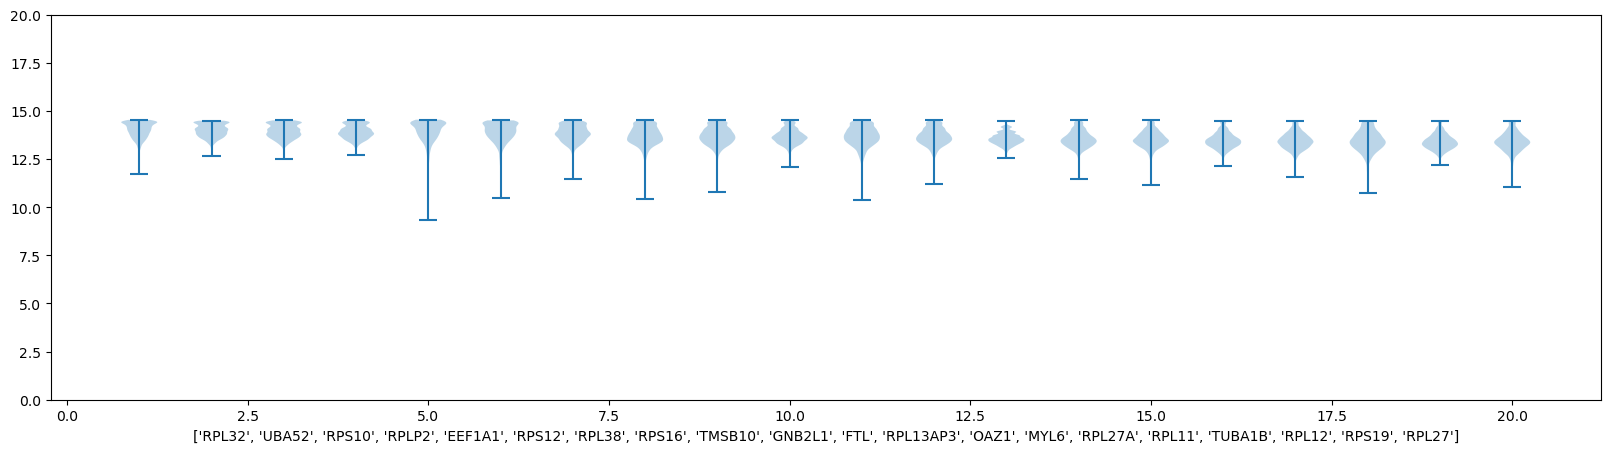

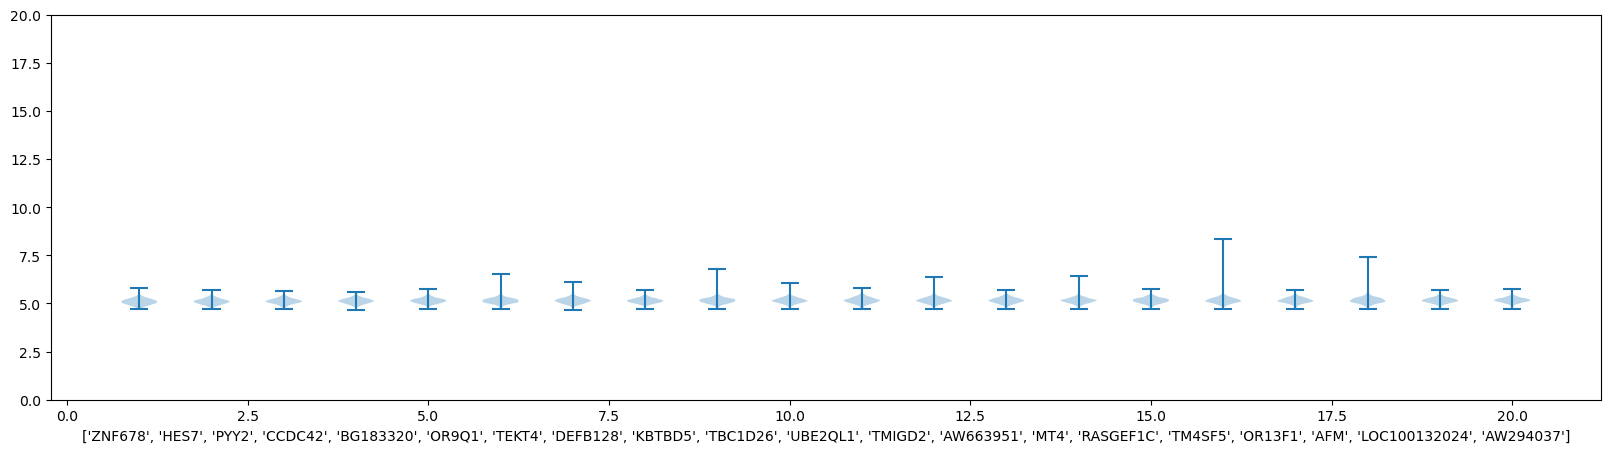

In [285]:
def plot_violin(df: pd.DataFrame()):
    plt.style.use("default")
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot((111), xlabel=df.columns.tolist(), ylim=(0, 20))
    plt.violinplot(df)
    plt.show()


head_num = 20
# 平均値の高い順でデータのバイオリンプロット
plot_violin(df_tmp[df_tmp.mean().sort_values(ascending=False).head(head_num).index])
# 平均値の低い順でデータのバイオリンプロット
plot_violin(df_tmp[df_tmp.mean().sort_values(ascending=True).head(head_num).index])

### 目的変数との関係性の確認

In [91]:
# 目的変数の各カテゴリ（T/F）に属しているデータ数の差
df_MB_genes[df_MB_genes.target_OS_5years == True].shape, df_MB_genes[
    df_MB_genes.target_OS_5years == False
].shape

((472, 24369), (1432, 24369))

## 特徴量選択

特徴量選択手法によって、膨大な遺伝子の数を削減する  
- filter method
- wrapper method
- embedded method
の3つの手法がある

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

nullを含んでいるとできない手法もあるので、nullを削除する

In [43]:
print(df_MB_genes.shape, df_MB_genes.dropna().shape)
df_MB_genes.dropna(inplace=True)

(1903, 22545) (1903, 22545)


In [45]:
# null削除後の重複columns
show_duplicate_columns(df_MB_genes)

PALM2AKAP2


### 低分散変数の確認

分散が小さな特徴量を切り捨てる方法。今回は特徴量の値が全て同じものを切り捨てるために使用した（閾値（切り捨てたい分散の値）=0）。

In [15]:
sel = VarianceThreshold()
sel.fit_transform(df_MB_genes)

df_tmp = pd.DataFrame(
    sel.fit_transform(df_MB_genes),
    columns=df_MB_genes.columns.values[sel.get_support()],
)
print("Before Feature Selection:", df_MB_genes.shape)
print("After Feature Selection:", df_tmp.shape)

result = pd.DataFrame(
    sel.get_support(), index=df_MB_genes.columns.values, columns=["False: dropped"]
)
result["variance"] = sel.variances_
print(result)

Before Feature Selection: (1894, 24369)
After Feature Selection: (1894, 24369)
                  False: dropped  variance
target_OS_5years            True  0.186838
RERE                        True  0.248863
RNF165                      True  0.561938
CD049690                    True  0.018860
BC033982                    True  0.018509
...                          ...       ...
CC2D1A                      True  0.085417
CB986545                    True  0.019425
IGSF9                       True  0.488735
DA110839                    True  0.019254
FAM71A                      True  0.052879

[24369 rows x 2 columns]


In [16]:
# dropするべき特徴量の確認
result[result["False: dropped"] == False]

Empty DataFrame
Columns: [False: dropped, variance]
Index: []

### filter method
データセットのみに注目して実施する特徴量選択

- χ^2検定
- ANOVA
- Mutual information

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection  
https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d#122-%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95

In [17]:
# 実際にはtrainデータに実施した内容をtestデータに適用するので、それに習いこのEDAノートブックでも同様の処理（trainデータに対しての特徴量選択の実施）を行う
X, y = df_MB_genes.drop("target_OS_5years", axis=1), df_MB_genes.target_OS_5years
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)

In [18]:
def transform_minmaxscaler(df: pd.DataFrame) -> pd.DataFrame:
    mm = MinMaxScaler()
    mm.fit(df)
    df_tmp = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df_tmp


def feature_selection(
    X: pd.DataFrame, y: pd.Series, feature_selecton_method
) -> pd.DataFrame:
    selector = SelectKBest(feature_selecton_method, k="all")
    # 特徴量選択の実施（fit）
    selector.fit(X, y)
    selector.transform(X),
    # 返り値のためのdf作成
    result = pd.DataFrame(
        selector.get_support(),
        index=X.columns.values,
        columns=["False: dropped"],
    )
    result["score"] = selector.scores_
    result["pvalue"] = selector.pvalues_
    return result

In [19]:
# 各特徴量選択手法の説明
# https://medium.com/swlh/feature-selection-methods-in-machine-learning-67d71a6bce21
X_train = transform_minmaxscaler(X_train)

# χ^2検定
result_chi2 = feature_selection(X_train, y_train, chi2)

# ANOVA
result_f_classif = feature_selection(X_train, y_train, f_classif)

"""
Mutual information（相互情報量評価）

Mutual information (MI) measures the dependence of one variable to another 
by quantifying the amount of information obtained about one feature, through the other feature. 
MI is symmetric and non-negative and is equal to zero if and only if two random variables are 
independent, and higher values mean higher dependency.

利点：MI can capture non-linear relationships between input and output feature.
"""
result_mic = feature_selection(X_train, y_train, mutual_info_classif)

In [20]:
result_chi2[result_chi2.pvalue < 0.05].head(10)

False: dropped     score    pvalue
FGFR4              True  3.969947  0.046319
CDCA5              True  4.820622  0.028121
FAM83D             True  5.715385  0.016817
MELK               True  4.082387  0.043332
AGTR1              True  5.399949  0.020137
GLYATL2            True  7.710652  0.005490
KRT81              True  6.314594  0.011975
RAI2               True  4.746467  0.029359
ADCY1              True  4.567419  0.032586
FUT3               True  4.759877  0.029131

In [21]:
result_f_classif[result_f_classif.score > 50].head(10)

False: dropped      score        pvalue
MRFAP1L1            True  54.233165  3.007897e-13
CDCA5               True  67.055488  5.825366e-16
FAM83D              True  70.143453  1.308166e-16
MELK                True  59.540107  2.246404e-14
RABEP1              True  58.982557  2.948486e-14
ECE2                True  50.848191  1.585061e-12
GPR126              True  52.611284  6.664857e-13
HEXIM2              True  54.352972  2.836360e-13
STC2                True  62.760655  4.682163e-15
LRRC48              True  57.736578  5.417154e-14

In [22]:
result_mic.sort_values("score", ascending=False).head(10)

False: dropped     score pvalue
PPIL1               True  0.049686   None
IFT46               True  0.045686   None
ABHD14A             True  0.045569   None
VANGL1              True  0.045382   None
BX098805            True  0.045150   None
LONRF2              True  0.044092   None
BU729210            True  0.043427   None
ZNF609              True  0.042867   None
LZTFL1              True  0.042737   None
SLC27A2             True  0.042324   None

In [23]:
"""
入力:feature_selection()によって出力されたpd.Dataframe

出力：なし

内容：sortした後の特徴量選択結果の可視化グラフの表示
"""


def plot_selection_result(df_result: pd.DataFrame, show_p=False):
    pd.options.display.float_format = None

    # p値の表示の有無でレイアウト変更
    ncols = 3 if show_p else 2
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 8))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)

    df_result = df_result.sort_values("score", ascending=True).copy()
    df_result["score"].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
    axes[0].invert_xaxis()
    axes[0].set_yticklabels([])
    axes[0].set_ylabel("")
    axes[0].grid(axis="x", linestyle="dotted")
    axes[0].set_title("Score")
    if show_p:
        df_result["pvalue"].plot.barh(ax=axes[1], color="green")
        axes[1].set_ylabel("")
        axes[1].grid(axis="x", linestyle="dotted")
        axes[1].set_title("pvalue")
    axes[-1].axis("tight")
    axes[-1].axis("off")
    axes[-1].table(
        cellText=df_result.round(2).values,  # roundしないと表が小さすぎる
        colLabels=df_result.columns,
        rowLabels=df_result.index,
        loc="center",
    )
    plt.show()

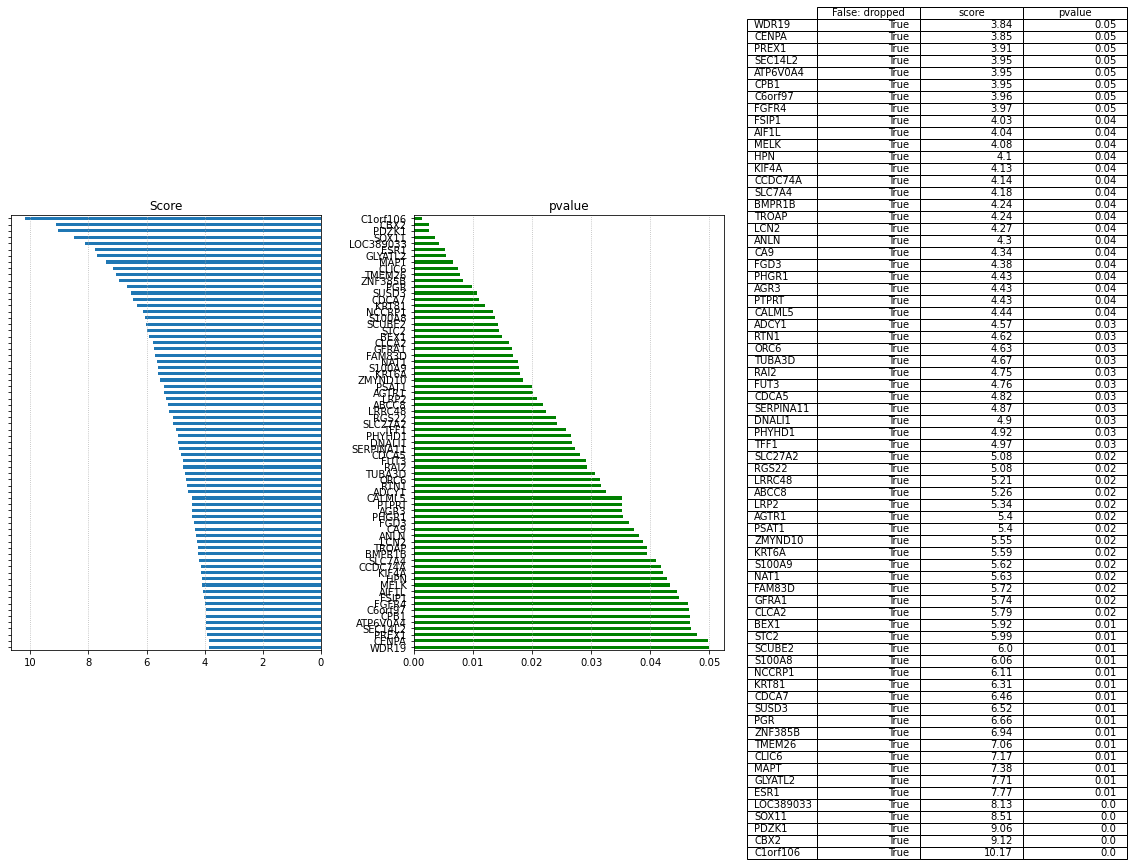

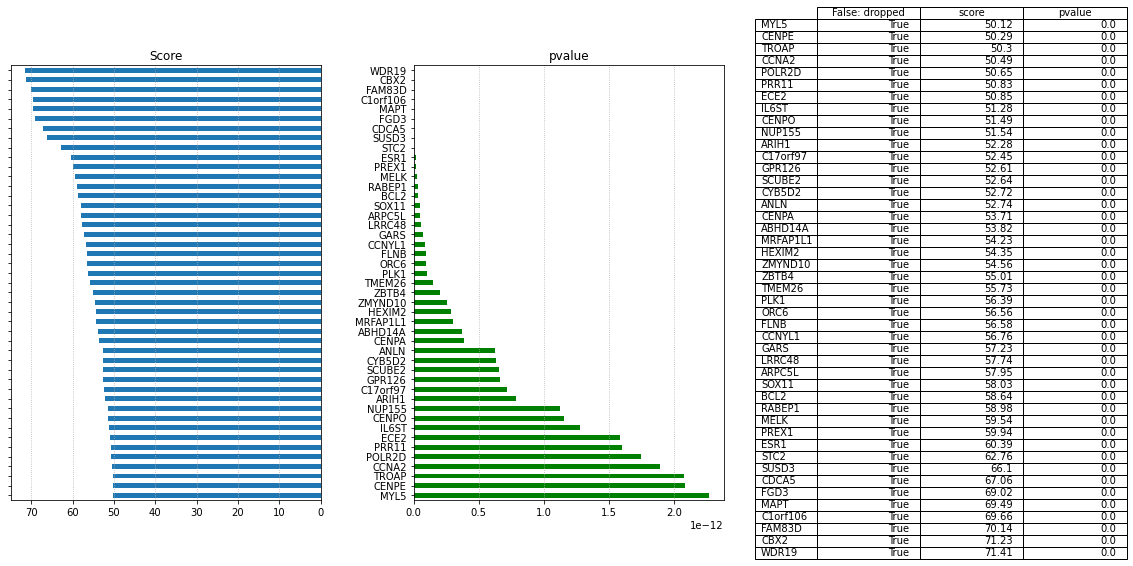

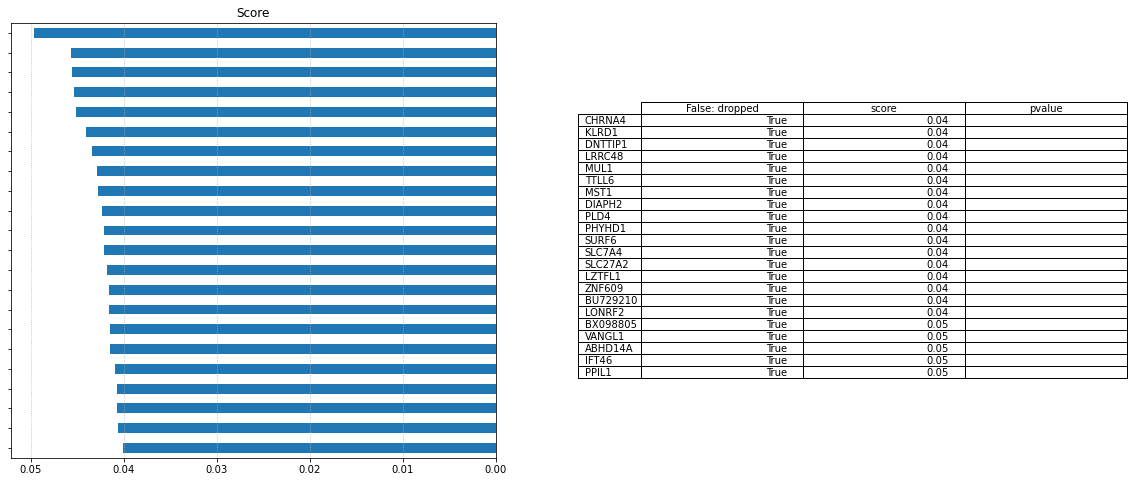

In [24]:
result_chi2 = feature_selection(X_train, y_train, chi2)

plot_selection_result(result_chi2[result_chi2.pvalue < 0.05], show_p=True)
plot_selection_result(result_f_classif[result_f_classif.score > 50], show_p=True)
plot_selection_result(result_mic[result_mic.score > 0.04])

# data_cnaについてEDA

patient_idをキーとしてmerge  
5年後の生存の有無と遺伝子情報を紐付ける

df_cnaを使うのは誤りでは（少なくとも優先度はz-scoreなどと比べると低い）？

### df_MBの読み込み

df_MB（patient_idと目的変数のみ）とdf_cnaをpatient_id（Hugo_Symbol：reset_indexによってindexがHugo_Symbolとなっている）をキーとして結合

In [25]:
df_MB_genes = pd.merge(
    df_MB[
        [
            "PATIENT_ID",
            "target_OS_5years",
            # "HORMONE_THERAPY",
            # "RADIO_THERAPY",
            # "BREAST_SURGERY",
        ]
    ],
    df_cna.reset_index(),
    right_on="index",
    left_on="PATIENT_ID",
).drop("index", axis=1)

df_MB_genes = df_MB_genes.set_index("PATIENT_ID")

print(
    df_cna.shape,
    df_MB.shape,
    df_MB_genes.shape,
    df_MB_genes[df_MB_genes.target_OS_5years != np.nan].shape,
)

df_MB_genes.head()

(2173, 22544) (1985, 34) (1985, 22545) (1985, 22545)


target_OS_5years  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  A4GALT  A4GNT  AAAS  AACS  AACSP1  AADAC  AADACL2  AADACL3  AADACL4  AADAT  AAED1  AAGAB  AAK1  AAMDC  AAMP  AANAT  ...  ZSCAN4  ZSCAN5A  ZSCAN5B  ZSCAN9  ZSWIM1  ZSWIM2  ZSWIM3  ZSWIM4  ZSWIM5  ZSWIM6  ZSWIM7  ZSWIM8  ZSWIM8-AS1  ZUFSP  ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3
PATIENT_ID                                                                                                                                                                                                   ...                                                                                                                                                                                              
MB-0000                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    0.0   0.0    0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0         0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0    0.0   0.0
MB-0002                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0  -1.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0   -1.0   0.0    1.0  -1.0   -1.0  ...     0.0      0.0      0.0    -1.0     1.0     0.0     1.0     0.0     0.0     0.0    -1.0    -1.0        -1.0   -1.0  -1.0    -1.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0   -1.0   0.0
MB-0005                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    1.0   0.0    0.0  ...     0.0      0.0      0.0     0.0     1.0     0.0     1.0     1.0     0.0     0.0     0.0     0.0         0.0    0.0   1.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  2.0    0.0   0.0
MB-0006                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0  ...     0.0      0.0      0.0     0.0    -1.0     0.0    -1.0     0.0     0.0     0.0     1.0     0.0         0.0    0.0   0.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  1.0    1.0   0.0
MB-0008                 True   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0    -1.0     0.0    -1.0     0.0     0.0         0.0   -1.0  -1.0     0.0    0.0   0.0   0.0   1.0    -1.0    -1.0  0.0   -1.0   0.0

[5 rows x 22545 columns]

In [26]:
# 遺伝子のdfとdf_MBを結合したら、遺伝子のdfで見られないpatient_idがあったのでsortしてpatient_idの確認
# sortした結果、無事あったので、結合処理は大丈夫だろう
df_cna.sort_index().head()

Hugo_Symbol  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  A4GALT  A4GNT  AAAS  AACS  AACSP1  AADAC  AADACL2  AADACL3  AADACL4  AADAT  AAED1  AAGAB  AAK1  AAMDC  AAMP  AANAT  AAR2  ...  ZSCAN4  ZSCAN5A  ZSCAN5B  ZSCAN9  ZSWIM1  ZSWIM2  ZSWIM3  ZSWIM4  ZSWIM5  ZSWIM6  ZSWIM7  ZSWIM8  ZSWIM8-AS1  ZUFSP  ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3
MB-0000       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    0.0   0.0    0.0   0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0         0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0    0.0   0.0
MB-0002       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0  -1.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0   -1.0   0.0    1.0  -1.0   -1.0   0.0  ...     0.0      0.0      0.0    -1.0     1.0     0.0     1.0     0.0     0.0     0.0    -1.0    -1.0        -1.0   -1.0  -1.0    -1.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0   -1.0   0.0
MB-0005       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    1.0   0.0    0.0   1.0  ...     0.0      0.0      0.0     0.0     1.0     0.0     1.0     1.0     0.0     0.0     0.0     0.0         0.0    0.0   1.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  2.0    0.0   0.0
MB-0006       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0   1.0  ...     0.0      0.0      0.0     0.0    -1.0     0.0    -1.0     0.0     0.0     0.0     1.0     0.0         0.0    0.0   0.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  1.0    1.0   0.0
MB-0008       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0   0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0    -1.0     0.0    -1.0     0.0     0.0         0.0   -1.0  -1.0     0.0    0.0   0.0   0.0   1.0    -1.0    -1.0  0.0   -1.0   0.0

[5 rows x 22544 columns]

In [27]:
# 目的変数の各カテゴリ（T/F）に属しているデータ数の差
df_MB_genes[df_MB_genes.target_OS_5years == True].shape, df_MB_genes[
    df_MB_genes.target_OS_5years == False
].shape

((495, 22545), (1490, 22545))

## 特徴量選択

特徴量選択手法によって、膨大な遺伝子の数を削減する  
- filter method
- wrapper method
- embedded method
の3つの手法がある

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

nullを含んでいるとできない手法もあるので、nullを削除する

In [28]:
df_MB_genes.shape, df_MB_genes.dropna().shape
df_MB_genes.dropna(inplace=True)

### 低分散変数の確認

分散が小さな特徴量を切り捨てる方法。今回は特徴量の値が全て同じものを切り捨てるために使用した（閾値（切り捨てたい分散の値）=0）。

In [29]:
sel = VarianceThreshold()
sel.fit_transform(df_MB_genes)

df_tmp = pd.DataFrame(
    sel.fit_transform(df_MB_genes),
    columns=df_MB_genes.columns.values[sel.get_support()],
)
print("Before Feature Selection:", df_MB_genes.shape)
print("After Feature Selection:", df_tmp.shape)

result = pd.DataFrame(
    sel.get_support(), index=df_MB_genes.columns.values, columns=["False: dropped"]
)
result["variance"] = sel.variances_
print(result)

Before Feature Selection: (1903, 22545)
After Feature Selection: (1903, 22545)
                  False: dropped  variance
target_OS_5years            True  0.187039
A1BG                        True  0.264711
A1BG-AS1                    True  0.265249
A1CF                        True  0.200415
A2M                         True  0.272307
...                          ...       ...
ZYG11A                      True  0.292155
ZYG11B                      True  0.297476
ZYX                         True  0.295012
ZZEF1                       True  0.300793
ZZZ3                        True  0.245128

[22545 rows x 2 columns]


In [30]:
# dropするべき特徴量の確認
result[result["False: dropped"] == False]

Empty DataFrame
Columns: [False: dropped, variance]
Index: []

### filter method
データセットのみに注目して実施する特徴量選択

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection  
https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d#122-%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95

In [31]:
# 実際にはtrainデータに実施した内容をtestデータに適用するので、それに習いこのEDAノートブックでも同様の処理（trainデータに対しての特徴量選択の実施）を行う
X, y = df_MB_genes.drop("target_OS_5years", axis=1), df_MB_genes.target_OS_5years
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)

In [32]:
def transform_minmaxscaler(df: pd.DataFrame) -> pd.DataFrame:
    mm = MinMaxScaler()
    mm.fit(df)
    df_tmp = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df_tmp


def feature_selection(
    X: pd.DataFrame, y: pd.Series, feature_selecton_method
) -> pd.DataFrame:
    selector = SelectKBest(feature_selecton_method, k="all")
    # 特徴量選択の実施（fit）
    selector.fit(X, y)
    selector.transform(X),
    # 返り値のためのdf作成
    result = pd.DataFrame(
        selector.get_support(),
        index=X.columns.values,
        columns=["False: dropped"],
    )
    result["score"] = selector.scores_
    result["pvalue"] = selector.pvalues_
    return result

In [33]:
X_train = transform_minmaxscaler(X_train)

# χ^2検定
result_chi2 = feature_selection(X_train, y_train, chi2)

# ANOVA
result_f_classif = feature_selection(X_train, y_train, f_classif)

# 相互情報量評価
result_mic = feature_selection(X_train, y_train, mutual_info_classif)

In [34]:
result_chi2[result_chi2.pvalue < 0.05]

False: dropped     score    pvalue
AARSD1            True  4.924399  0.026480
ACBD4             True  5.842483  0.015644
ADAM11            True  5.914680  0.015015
AOC2              True  4.599974  0.031972
AOC3              True  4.599974  0.031972
...                ...       ...       ...
TUBG2             True  4.295642  0.038210
UBTF              True  5.560022  0.018375
VPS25             True  4.948119  0.026119
WNK4              True  4.948119  0.026119
WNT5A             True  4.808695  0.028316

[83 rows x 3 columns]

In [35]:
result_f_classif[result_f_classif.pvalue < 0.05]

False: dropped      score        pvalue
A1CF               True   4.333582  3.754564e-02
A2ML1              True   4.150579  4.180473e-02
A2MP1              True   3.899113  4.850440e-02
A3GALT2            True   4.256097  3.929049e-02
AADACL3            True   5.196417  2.278076e-02
...                 ...        ...           ...
ZSWIM6             True   7.664398  5.705061e-03
ZSWIM7             True  27.625055  1.696668e-07
ZWILCH             True   5.732714  1.678030e-02
ZYX                True   5.401018  2.026504e-02
ZZEF1              True  27.151511  2.157427e-07

[8456 rows x 3 columns]

In [36]:
result_mic.sort_values("score", ascending=False)

False: dropped     score pvalue
PNPLA4               True  0.059308   None
B4GALT6              True  0.048759   None
MIR635               True  0.045895   None
DDIT3                True  0.045378   None
FZD2                 True  0.045367   None
...                   ...       ...    ...
RMST                 True  0.000000   None
MIR3179-3            True  0.000000   None
RMND5B               True  0.000000   None
MIR3180-3            True  0.000000   None
A1BG                 True  0.000000   None

[22544 rows x 3 columns]

In [37]:
"""
入力:feature_selection()によって出力されたpd.Dataframe

出力：なし

内容：sortした後の特徴量選択結果の可視化グラフの表示
"""


def plot_selection_result(df_result: pd.DataFrame, show_p=False):
    pd.options.display.float_format = None

    # p値の表示の有無でレイアウト変更
    ncols = 3 if show_p else 2
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(40, 20))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)

    df_result = df_result.sort_values("score", ascending=True).copy()
    df_result["score"].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
    axes[0].invert_xaxis()
    axes[0].set_yticklabels([])
    axes[0].set_ylabel("")
    axes[0].grid(axis="x", linestyle="dotted")
    axes[0].set_title("Score")
    if show_p:
        df_result["pvalue"].plot.barh(ax=axes[1], color="green")
        axes[1].set_ylabel("")
        axes[1].grid(axis="x", linestyle="dotted")
        axes[1].set_title("pvalue")
    axes[-1].axis("tight")
    axes[-1].axis("off")
    axes[-1].table(
        cellText=df_result.round(2).values,  # roundしないと表が小さすぎる
        colLabels=df_result.columns,
        rowLabels=df_result.index,
        loc="center",
    )
    plt.show()

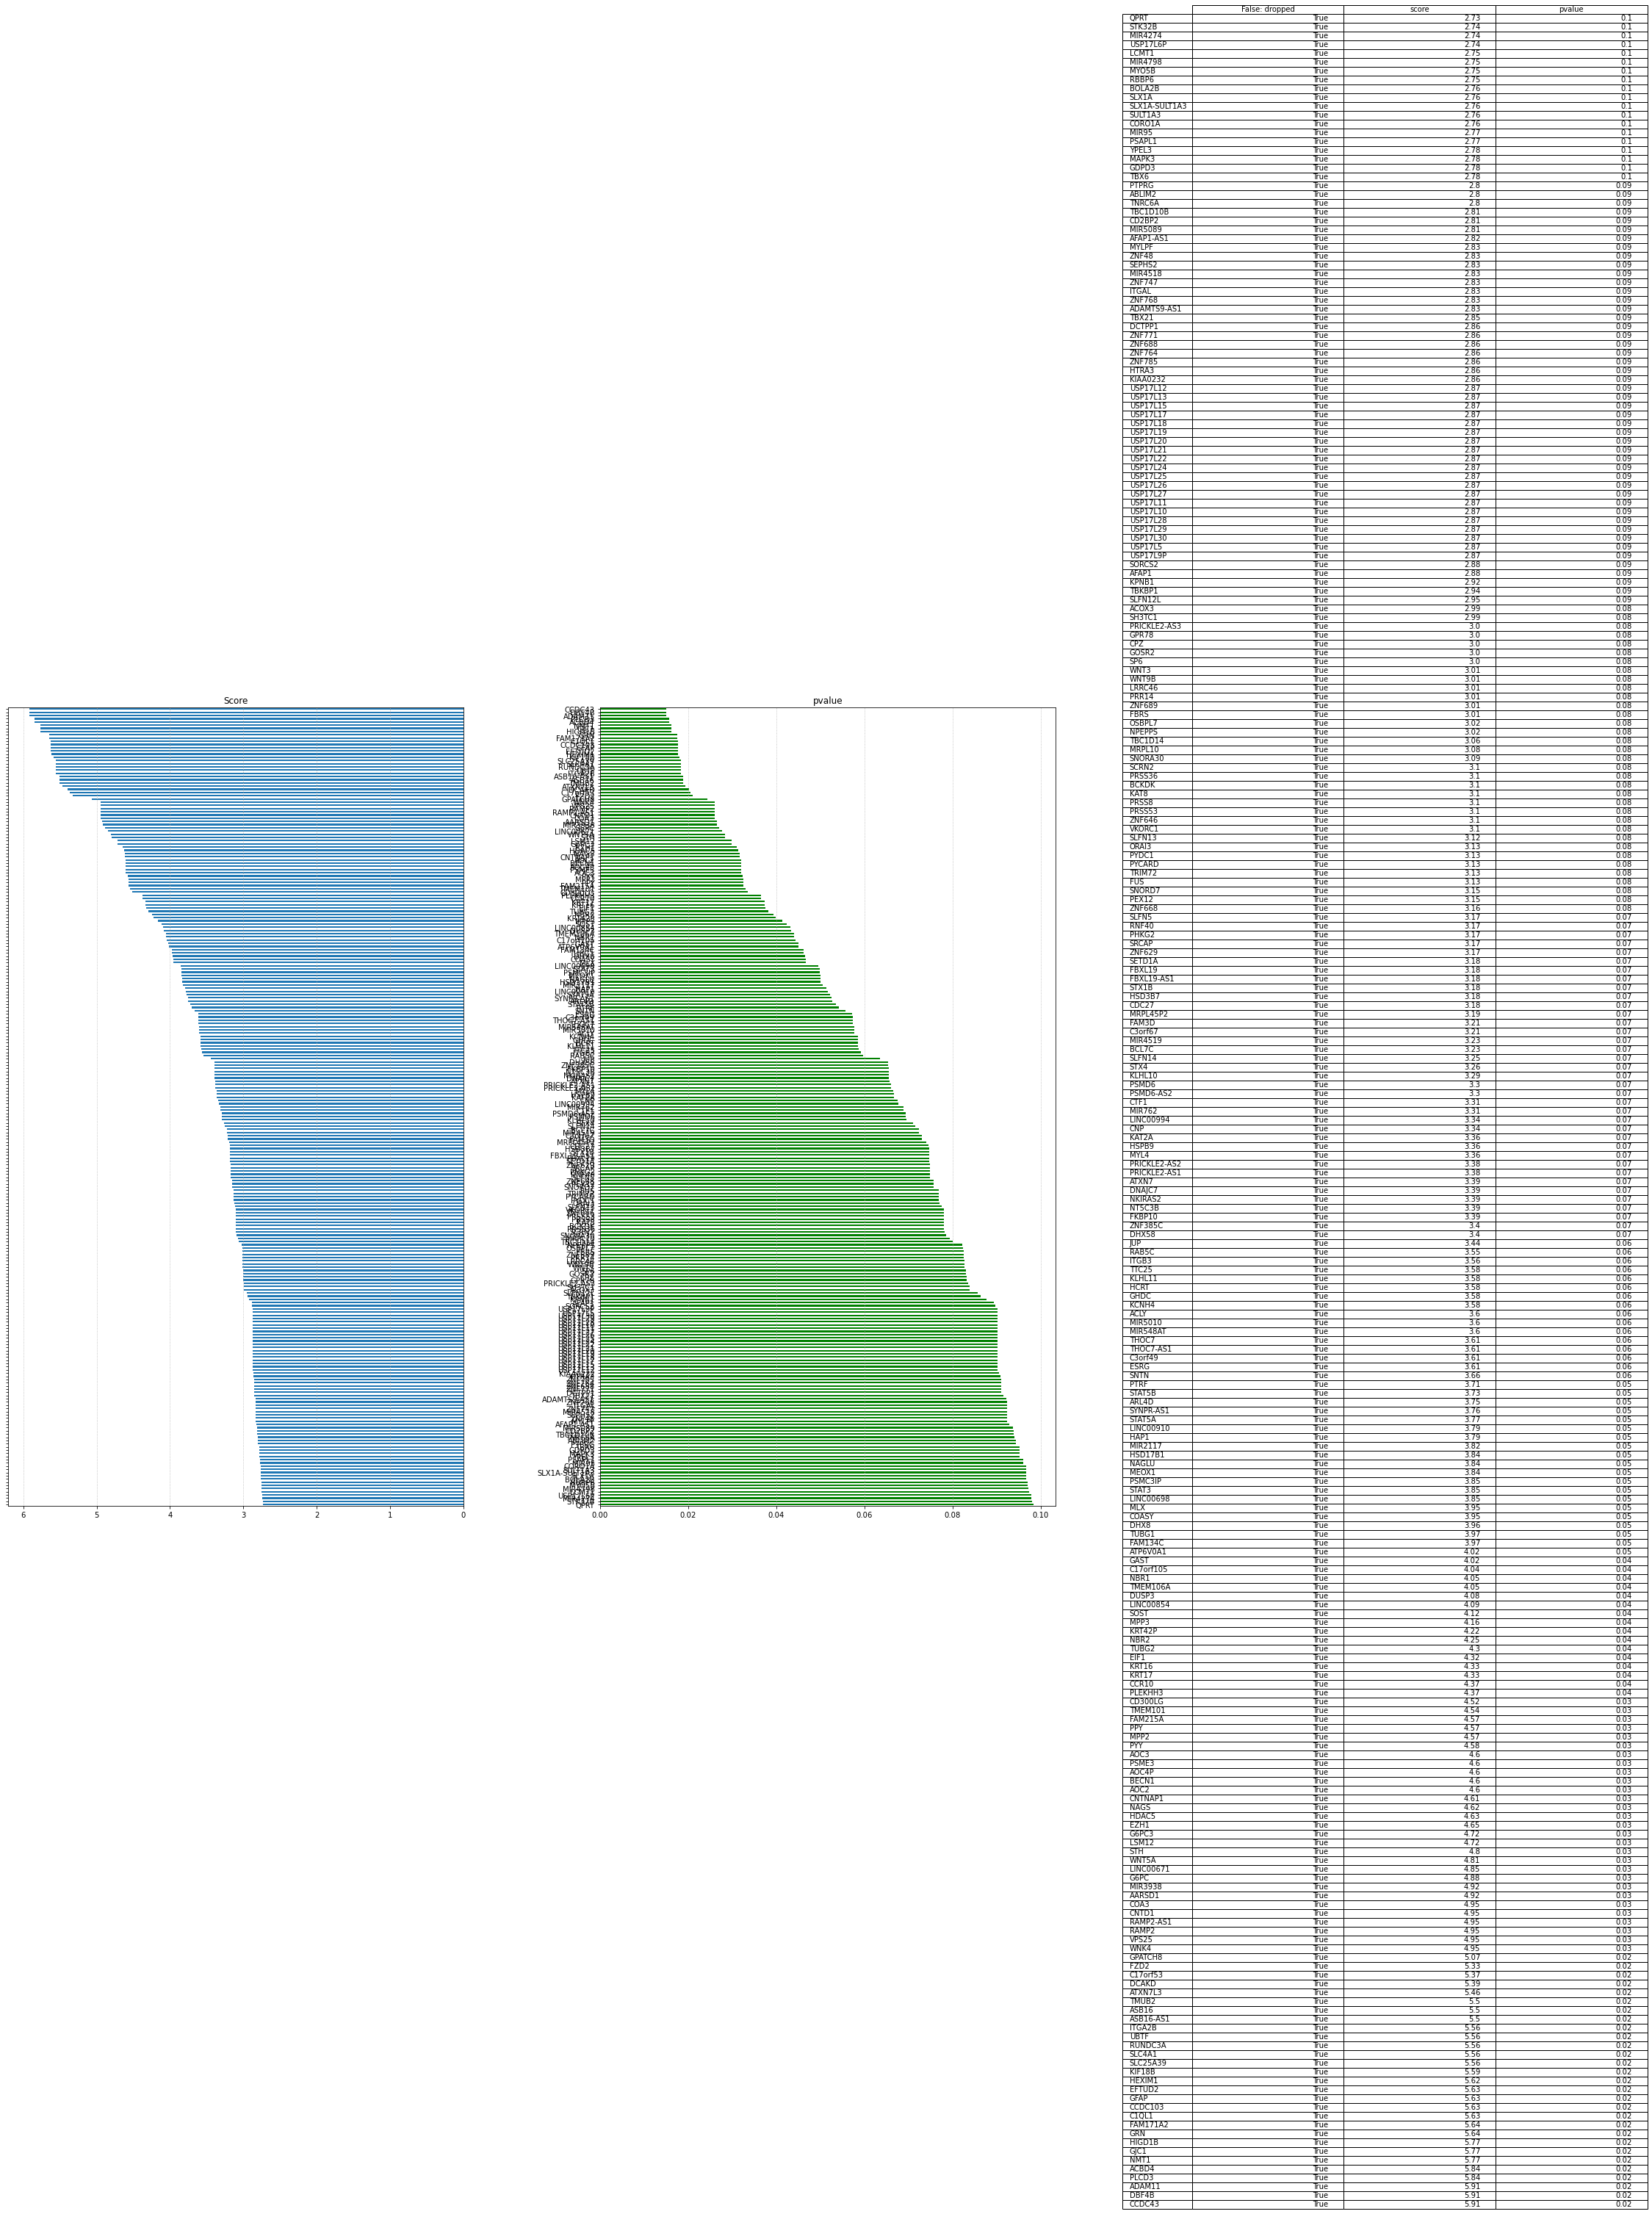

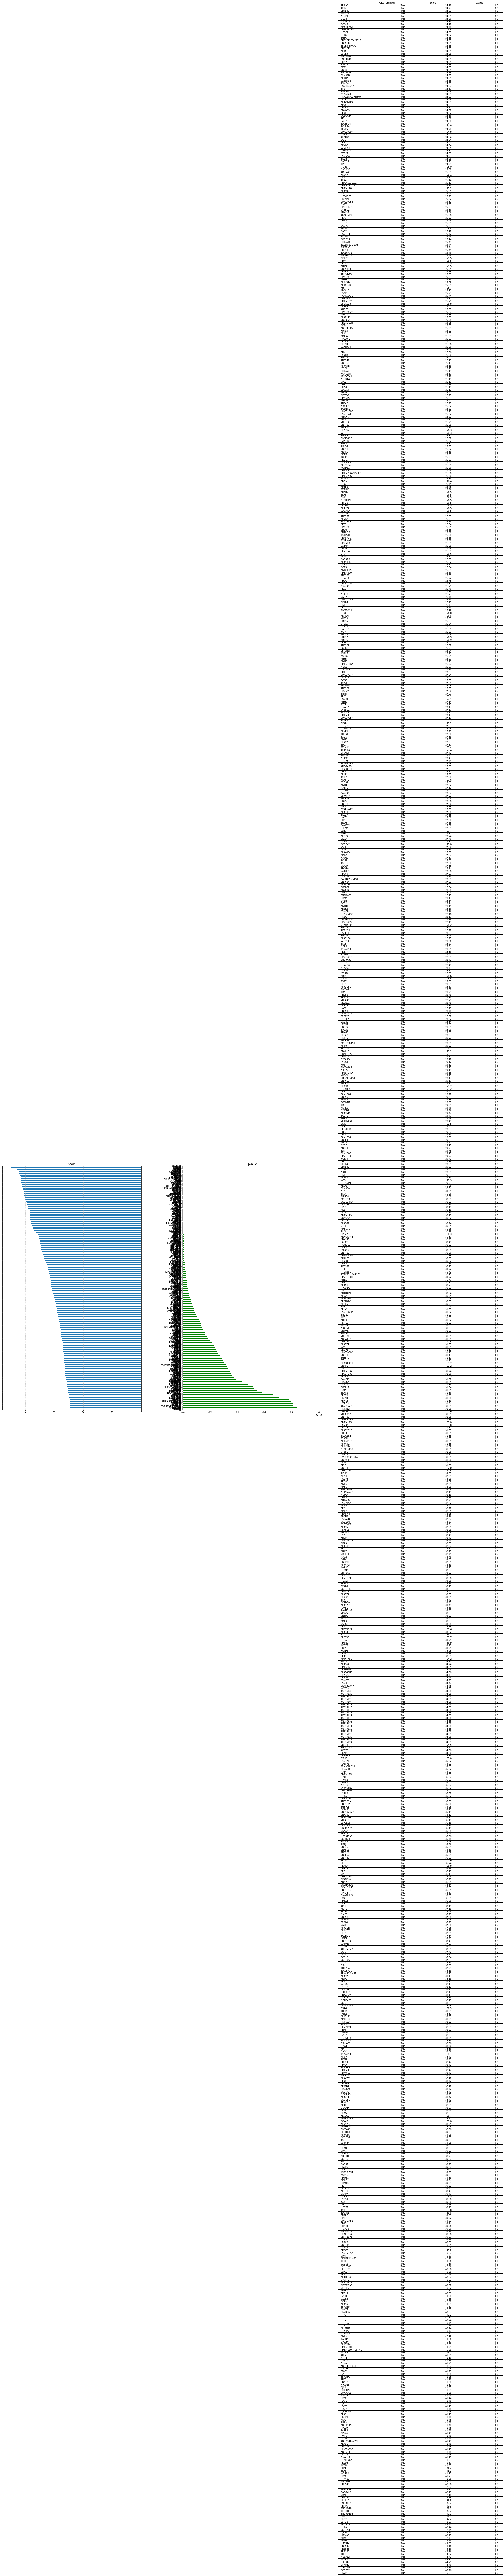

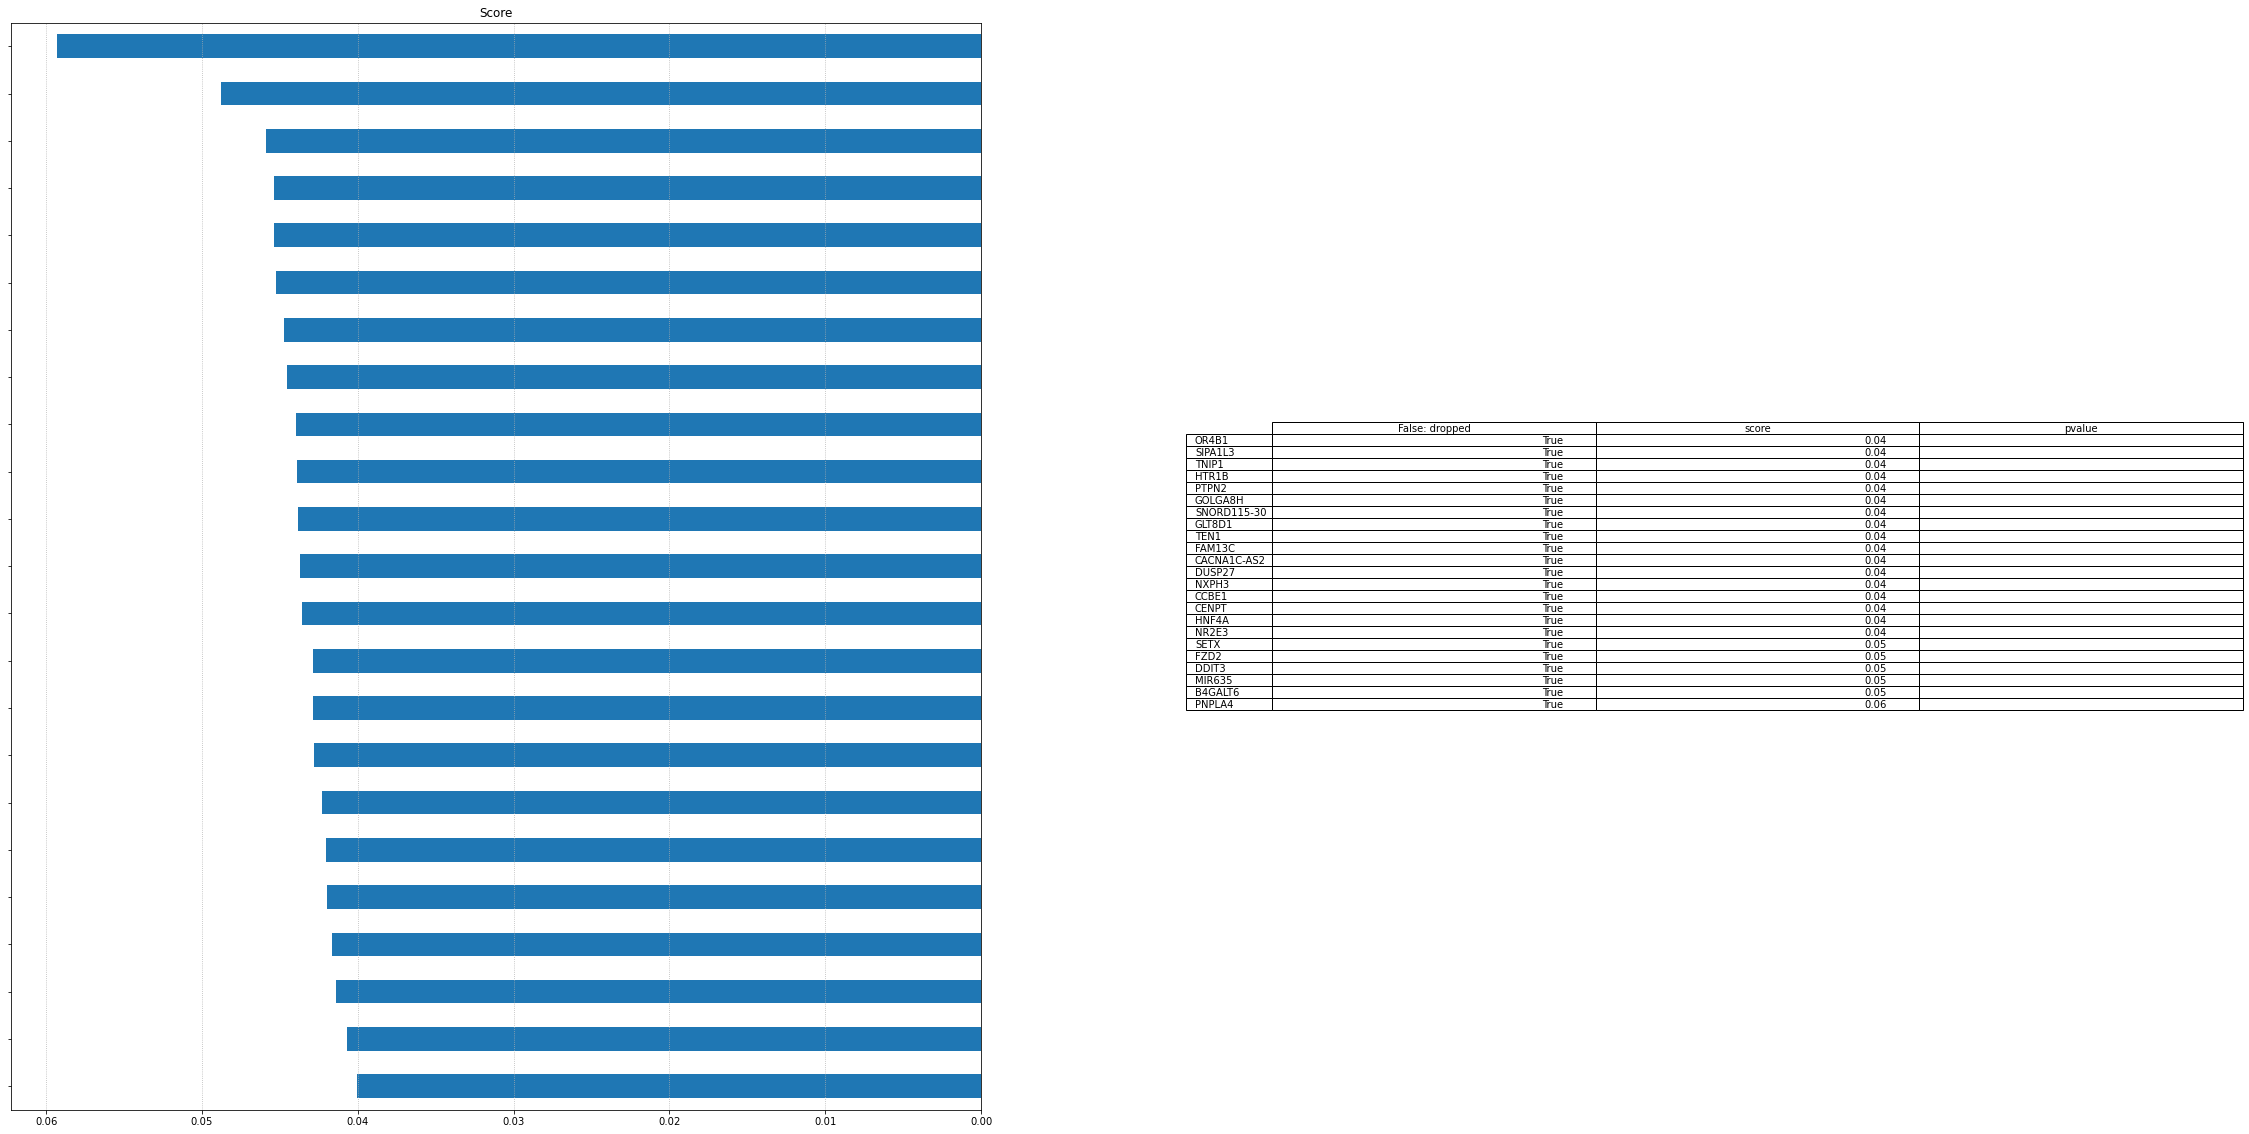

In [38]:
result_chi2 = feature_selection(X_train, y_train, chi2)

plot_selection_result(result_chi2[result_chi2.pvalue < 0.1], show_p=True)
plot_selection_result(result_f_classif[result_f_classif.pvalue < 0.000001], show_p=True)
plot_selection_result(result_mic[result_mic.score > 0.04])